### model_test.ipynb
#### This notebook tests stock prediction model generated from stock_prediction.py

In [137]:
# import modules
import yfinance as yf           # must pip install yfinance at cmd prompt
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

In [138]:
### get the data
df = yf.download('SPY') # loads all data to 'data' 
df[:5]

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,25.334032,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,25.514215,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,25.568262,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,25.838551,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,25.946672,531500


In [139]:
raw_data = np.array(df)
raw_data.shape

(7521, 6)

In [140]:
# data loaded to SPY.txt for further use
outfile = open('SPY.txt', 'w')
for row in range(raw_data.shape[0]):
    for col in range(raw_data.shape[1]):
        outfile.write(str(raw_data[row,col])+' ')
    outfile.write('\n')
outfile.close()

In [141]:
raw_data = np.loadtxt('SPY.txt')
raw_data.shape

(7521, 6)

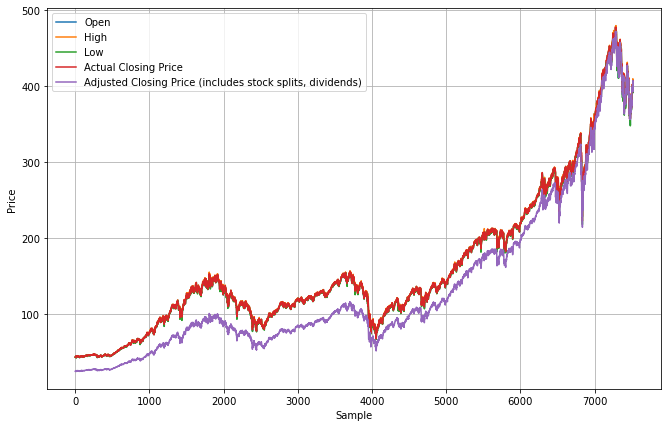

In [142]:
#### Shows why ACP is used rather than Closing Price
dataPoints = 7521
plt.plot(raw_data[:dataPoints,0], label='Open')
plt.plot(raw_data[:dataPoints,1], label='High')
plt.plot(raw_data[:dataPoints,2], label='Low')
plt.plot(raw_data[:dataPoints,3], label='Actual Closing Price')
plt.plot(raw_data[:dataPoints,4], label='Adjusted Closing Price (includes stock splits, dividends)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.rcParams['figure.figsize'] = (12,7)
plt.show()

In [143]:
# this scales all price data to Adjusted Closing Price data (& removes ACP col)
scaled_data = raw_data.copy()
scale_factor = scaled_data[:,4] / scaled_data[:,3]
for i in range(3):
    scaled_data[:,i] = scaled_data[:,i] * scale_factor
scaled_data = np.delete(scaled_data,[3],axis=1)
print(scaled_data.shape)

(7521, 5)


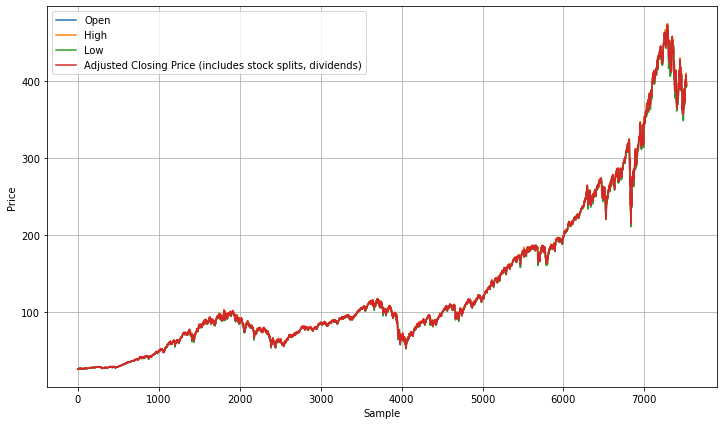

In [144]:
#### Shows why ACP is used rather than Closing Price
dataPoints = 7521
plt.plot(scaled_data[:dataPoints,0], label='Open')
plt.plot(scaled_data[:dataPoints,1], label='High')
plt.plot(scaled_data[:dataPoints,2], label='Low')
plt.plot(scaled_data[:dataPoints,3], label='Adjusted Closing Price (includes stock splits, dividends)')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.rcParams['figure.figsize'] = (12,7)
plt.show()

In [145]:
test_samples = 500           # save for test data 
train_samples = 3000         # train and validation data
samples = test_samples + train_samples  # total samples from data set to be used
features = 5                 # data columns representing features
non_features = 0             # data columns to keep data organized
data_step_width = features + non_features  # total # columns in data set
val_split = 0.2
split_point = int(train_samples * (1-val_split))
steps = 32                   # time steps to evaluate
maxConv = 8                  # longest convolution length to evaluate
sample_length = steps + maxConv - 1  # number of time steps needed for each sample     
first_step_idx = -samples - steps - maxConv + 1  # index of 1st datapoint
last_step_idx = -samples   # index representing sample length
print(first_step_idx, last_step_idx)

-3539 -3500


In [146]:
Y_price = scaled_data[-samples:,3]

In [147]:
def normalize(x):              #includes mean & std for pct change
    y_mean = np.mean(x[:,3])
    y_std = np.std(x[:,3])
    x_norm = preprocessing.StandardScaler().fit_transform(x)
    y_value = np.array([x_norm[-1,3], y_mean, y_std])    # returns ACP_norm, y_mean, & y_std to reconstruct ACP
    return x_norm, y_value

In [148]:
# prepare X and Y data samples
X = np.zeros(shape=(samples+1,sample_length,data_step_width))
Y = np.zeros(shape=(samples+1,3))
for i in range(samples+1):
    idxFirst = i + first_step_idx
    idxLast = i + last_step_idx
    X[i,:],Y[i,:] = normalize(scaled_data[idxFirst:idxLast or None])
Y = Y[1:]
X = X[:-1]
print(X.shape, Y.shape)
print(X[-1])
print(Y[-2:])

(3500, 39, 5) (3500, 3)
[[-2.76348855 -1.85508678 -2.47161185 -1.58122897  2.33664481]
 [-1.31983653 -1.627893   -1.84163484 -2.2144367   1.40751535]
 [-1.65872741 -1.8162572  -1.81885551 -1.51669291  0.19980311]
 [-0.82866503 -1.19911619 -1.08993416 -1.1894597   0.35762573]
 [-1.28699213 -1.496534   -1.23016632 -1.38914078 -0.33044565]
 [-1.35865159 -1.42878834 -1.29707926 -1.62374634  0.00680257]
 [-1.57587152 -1.25281855 -1.37324427 -0.94953888  1.69597909]
 [-0.77193339 -0.81825801 -0.69201701 -0.60180696 -0.10564511]
 [-0.55546065 -0.38948119 -0.29623312 -0.14246402 -0.36602655]
 [-0.34421367 -0.19698721 -0.10546108 -0.36264612  0.63119495]
 [-0.23597616 -0.41013517 -0.24925373 -0.51752987 -0.24254429]
 [-0.47484405 -0.03671213 -0.22433897  0.16882343  0.48164531]
 [ 0.01558027 -0.12924156  0.17286781 -0.04452345  0.33662328]
 [ 0.29177112  0.03516584  0.03263565 -0.17283557 -0.10680269]
 [-0.17402104 -0.11023899 -0.57456202 -0.90550385  1.53605069]
 [-1.10186941 -1.30238608 -0.99

In [149]:
# divide data into train & test samples
X_train = X[:train_samples]
X_test = X[-test_samples:]
X1_train = X_train[:,-steps:]   # data samples for shorter convolution
X2_train = X_train              # data samples for longer convolution
X1_test = X_test[:,-steps:]
X2_test = X_test
Y_train = Y[:train_samples]
Y_test = Y[-test_samples:]
print(X.shape, X_train.shape, X_test.shape)
print(Y.shape, Y_train.shape, Y_test.shape)

(3500, 39, 5) (3000, 39, 5) (500, 39, 5)
(3500, 3) (3000, 3) (500, 3)


In [150]:
#### shows Y value offset by X(ACP) value by 1 timestep
for i in range(-5,0,1):
    print(X[i,-1,3], '|', Y[i])

1.6627283247794908 | [  1.54256659 383.91794919  14.9050645 ]
1.5425665874437036 | [  1.00481706 384.93256476  14.58716434]
1.0048170596372883 | [  0.57089095 385.85794928  13.96420337]
0.5708909473546261 | [  0.48315083 386.79641098  13.17102723]
0.48315082601458753 | [  0.64777544 387.56269328  12.80122281]


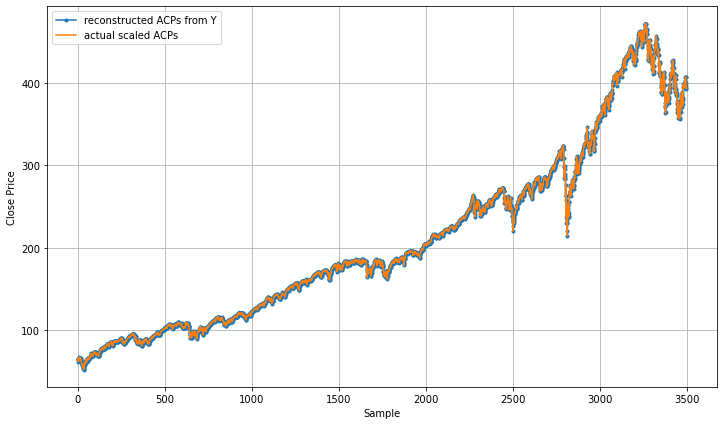

In [151]:
#### compares reconstructed ACP's with actual ACP's
temp = np.add(np.multiply(Y[:,0], Y[:,2]), Y[:,1])

plt.plot(temp, label='reconstructed ACPs from Y', marker='.')
plt.plot(scaled_data[-samples:,3], label='actual scaled ACPs')
plt.xlabel('Sample')
plt.ylabel('Close Price')
plt.legend()
plt.grid()
plt.show()

In [152]:
# load trained model
model = keras.models.load_model("stock_prediction.h5")

### Evaluate Test Data

In [153]:
# check a few predictions
Y_predict = model.predict([X1_test,X2_test])
print(Y_predict[-5:])
print(Y_test[-5:,-3])
print(Y_predict.shape, Y_test.shape)

[[1.1207392]
 [1.3950074]
 [2.119225 ]
 [1.2769105]
 [1.3536727]]
[1.54256659 1.00481706 0.57089095 0.48315083 0.64777544]
(500, 1) (500, 3)


In [154]:
# calculate actual ACPs for all test data
Y_predict_price = (Y_predict[:,0] * Y_test[:,-1]) + Y_test[:,-2]
Y_actual_price = (Y_test[:,0] * Y_test[:,-1]) + Y_test[:,-2]
print(Y_predict_price.shape, Y_actual_price.shape)
print(Y_actual_price[-5:])
print(Y_price[-5:])
print(Y_predict_price[-5:])

(500,) (500,)
[406.91000366 399.58999634 393.82998657 393.16000366 395.85501099]
[406.91000366 399.58999634 393.82998657 393.16000366 395.85501099]
[400.62263957 405.28176655 415.45123852 403.61463451 404.89135967]


In [155]:
# calculate actual error and std. dev. of price predictions
error = np.zeros(shape=Y_predict.shape)
print(error.shape)
for i in range(Y_predict.shape[0]):    
    error[i] = abs(Y_predict_price[i]-Y_actual_price[i])/Y_actual_price[i]
MAE = np.mean(error)
std = np.std(error)
# print(error[:10])
print('MAE:', MAE)
print('Std Dev:', std)

(500, 1)
MAE: 0.019528758651556694
Std Dev: 0.020901424757180997


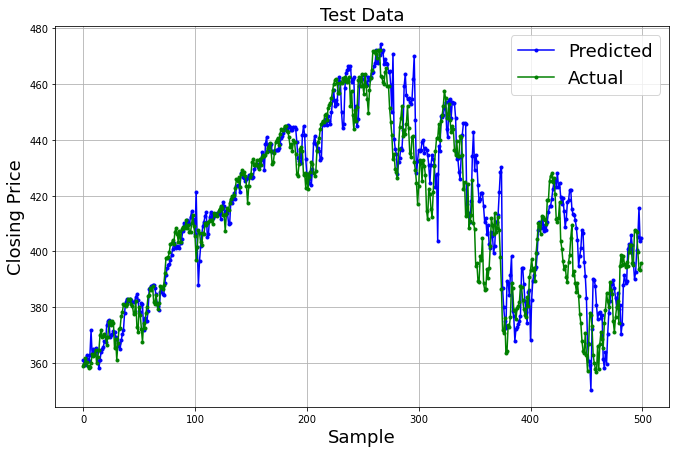

In [159]:
# plot predicted vs actual closing prices
plt.plot(Y_predict_price[:], label='Predicted', color='blue', marker='.')
plt.plot(Y_price[-500:], label='Actual', color='green', marker='.')
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend(fontsize=18)
plt.title('Test Data', fontsize=18)
plt.grid()
# plt.text(100,362,'MAE = '+ str(MAE), fontsize=18)
# plt.text(100,354,'Std Dev (MAE) = '+str(std), fontsize=18)
plt.rcParams['figure.figsize'] = (11,7)
plt.show()

In [157]:
# calculate how many trades were profitable
start_point = 0
wins = 0
losses = 0
for i in range(499):
    Y_predict_change = Y_predict[start_point+i+1]-Y_predict[start_point+i]
    Y_actual_change = Y_test[start_point+i+1,0]-Y_test[start_point+i,0]
    if np.sign(Y_predict_change) == np.sign(Y_actual_change):
        wins += 1
    else:
        losses += 1
print('winning trades:', wins, ' losing trades:', losses) 

winning trades: 231  losing trades: 268


### Evaluate training data

In [98]:
Y_train_predict = model.predict([X1_train,X2_train])
print(Y_train_predict[-5:])
Y_train_predict.shape

[[0.6577189]
 [1.2298895]
 [1.3374507]
 [1.6036408]
 [1.5813799]]


(3000, 1)

In [99]:
Y_train_predict_price = (Y_train_predict[:,0] * Y_train[:,-1]) + Y_train[:,-2]
Y_train_actual_price = (Y_train[:,0] * Y_train[:,-1]) + Y_train[:,-2]
print(Y_train_predict_price.shape, Y_train_actual_price.shape)
print(Y_train_actual_price[:5])
print(Y_price[:5])
print(Y_train_predict_price[:5])

(3000,) (3000,)
[64.67946625 65.18521881 61.74438095 64.41126251 63.41499329]
[64.67946625 65.18521881 61.74438095 64.41126251 63.41499329]
[64.59004927 61.14294358 61.66889584 63.3836419  63.52871894]


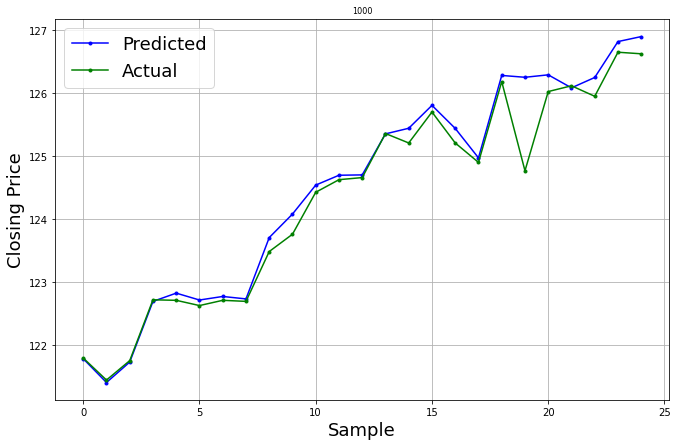

In [136]:
# examine training data predictions vs actual
i = 1000    # first sample number
n = 25     # number of samples to graph
plt.plot(Y_train_predict_price[i:i+n], label='Predicted', color='blue', marker='.')
plt.plot(Y_price[i:i+n], label='Actual', color='green', marker='.')
plt.xlabel('Sample', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend(fontsize=18, loc='upper left')
plt.grid()
plt.title(i, fontsize=8)
plt.rcParams['figure.figsize'] = (11,7)
plt.show()
i += n